## 🔹 Step 1: Unzip and Extract Dataset

In [19]:
### 📦 Unzip Dataset and List Files

import zipfile
import os

# Set paths
zip_path = r"C:\Users\Dragon\Downloads\archive (1).zip"
extract_dir = r"C:\Users\Dragon\Downloads\stock_data"

# Extract contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# List extracted files
print("Extracted files:", os.listdir(extract_dir))


Extracted files: ['AABA_2006-01-01_to_2018-01-01.csv', 'AAPL_2006-01-01_to_2018-01-01.csv', 'all_stocks_2006-01-01_to_2018-01-01.csv', 'all_stocks_2017-01-01_to_2018-01-01.csv', 'AMZN_2006-01-01_to_2018-01-01.csv', 'AXP_2006-01-01_to_2018-01-01.csv', 'BA_2006-01-01_to_2018-01-01.csv', 'CAT_2006-01-01_to_2018-01-01.csv', 'CSCO_2006-01-01_to_2018-01-01.csv', 'CVX_2006-01-01_to_2018-01-01.csv', 'DIS_2006-01-01_to_2018-01-01.csv', 'GE_2006-01-01_to_2018-01-01.csv', 'GOOGL_2006-01-01_to_2018-01-01.csv', 'GS_2006-01-01_to_2018-01-01.csv', 'HD_2006-01-01_to_2018-01-01.csv', 'IBM_2006-01-01_to_2018-01-01.csv', 'INTC_2006-01-01_to_2018-01-01.csv', 'JNJ_2006-01-01_to_2018-01-01.csv', 'JPM_2006-01-01_to_2018-01-01.csv', 'KO_2006-01-01_to_2018-01-01.csv', 'MCD_2006-01-01_to_2018-01-01.csv', 'MMM_2006-01-01_to_2018-01-01.csv', 'MRK_2006-01-01_to_2018-01-01.csv', 'MSFT_2006-01-01_to_2018-01-01.csv', 'NKE_2006-01-01_to_2018-01-01.csv', 'PFE_2006-01-01_to_2018-01-01.csv', 'PG_2006-01-01_to_2018-01-01.

## 🔹 Step 2: Load, Filter, and Prepare Apple Stock Data

In [29]:
### 📊 Data Preparation & Train-Test Split (Apple Stock)

import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV
csv_file = os.path.join(extract_dir, "all_stocks_2006-01-01_to_2018-01-01.csv")
df = pd.read_csv(csv_file)

# Filter Apple Inc.
stock_df = df[df["Name"] == "AAPL"].copy()
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date")

# Create target (next day Close)
stock_df["Target"] = stock_df["Close"].shift(-1)
stock_df.dropna(inplace=True)

# Define features and target
features = ["Open", "High", "Low", "Close", "Volume"]
X = stock_df[features]
y = stock_df["Target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


## 🔹 Step 3: Hyperparameter Tuning (SVR and Random Forest)

In [32]:
### ⚙️ Model Tuning: SVR & Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Feature scaling for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVR tuning
svr_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}
grid_svr = GridSearchCV(SVR(), svr_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train)
best_svr = grid_svr.best_estimator_

# Random Forest tuning
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_


## 🔹 Step 4: Model Evaluation and Visualization

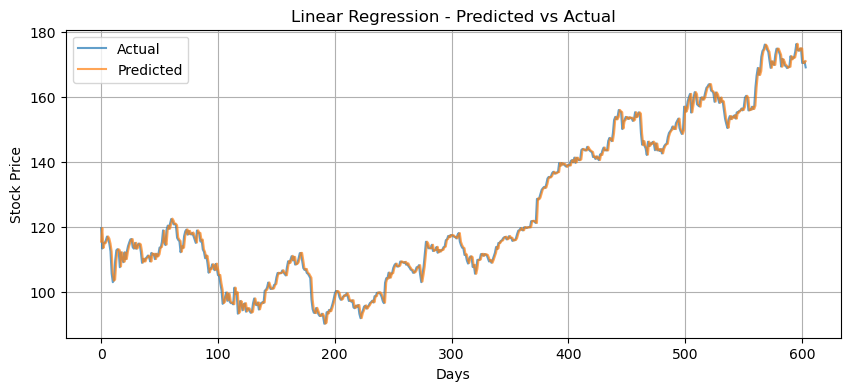

🔍 Linear Regression Evaluation:
MAE:  1.20
RMSE: 1.71
R²:   0.9950



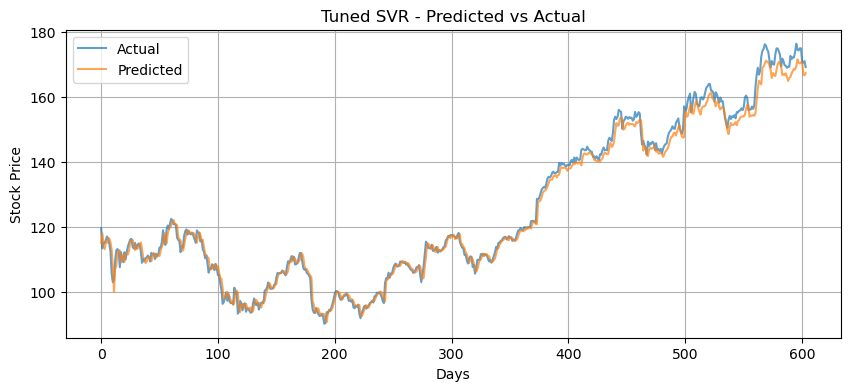

🔍 Tuned SVR Evaluation:
MAE:  1.73
RMSE: 2.34
R²:   0.9906



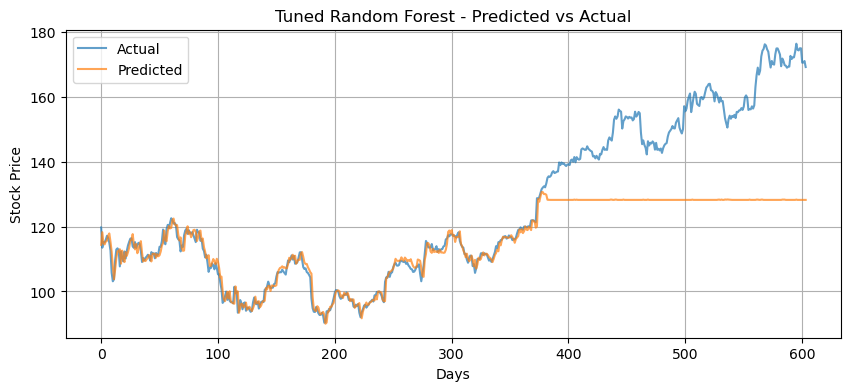

🔍 Tuned Random Forest Evaluation:
MAE:  10.39
RMSE: 17.17
R²:   0.4934



In [34]:
### 📈 Final Evaluation of Tuned Models

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

models = {
    "Linear Regression": LinearRegression(),
    "Tuned SVR": best_svr,
    "Tuned Random Forest": best_rf
}

results = {}

for name, model in models.items():
    # Use scaled features only for SVR
    X_tr = X_train_scaled if name == "Tuned SVR" else X_train
    X_te = X_test_scaled if name == "Tuned SVR" else X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values, label="Actual", alpha=0.7)
    plt.plot(y_pred, label="Predicted", alpha=0.7)
    plt.title(f"{name} - Predicted vs Actual")
    plt.xlabel("Days")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"🔍 {name} Evaluation:")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.4f}\n")
